# Imports


In [50]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Access functions

In [51]:
def retrieve_time(path):
    """
    This function retrieves the timing of a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output:
     - A float representing time or an error
    """
    f = open(path + "/job.out", "r")
    return float(f.readlines()[1][6:])

In [52]:
def retrieve_settings(path):
    """
    This function retrieves all the settings for a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output: 
     - A numpy array of settings in format np.float64
    """
    options = path.split("/")
    settings = np.array([], dtype=np.float64)
    for set in options:
        if not str.isalpha(set.split("_")[-1]):
            settings = np.append(settings, np.float64(set.split("_")[-1]))
    return settings

In [53]:
# These indexes allow us to rapidly swap the number of parameter in consideration during generation.

sequential_idx = {"seq_length": 0, "patterns": 1, "mean_path_length": 2, "time": 3}
pthreads_idx = {"threads": 0, "seq_length": 1, "patterns": 2, "mean_path_length": 3, "time": 4}

# Dataset creation

In [54]:
def create_dataset(path, dataset):
    """
    This function recursively explores the results folder and gathers data about the measurements.

    Input:
     - path: the path of the dataset
     - dataset: whatever numpy array of np.float64 with the same dimension as the measurement variables

     Output: 
      - The dataset as a numpy array of np.float64. The shape of the array is (measurements, variables),
        where the last variable is the timing of the measurement
    """
    new_dataset = np.copy(dataset)
    if not os.path.isdir(path) or os.listdir(path) == []:
        return dataset
    elif "job.out" in os.listdir(path):
        try:
            time = retrieve_time(path)
            settings = retrieve_settings(path)
            row = np.append(settings, np.float64(time)).reshape(1, -1)
            return np.append(new_dataset, row, axis=0)
        except:
            return new_dataset
    else:
        for dir in os.listdir(path):
            new_dataset = create_dataset(path + "/" + dir, new_dataset)

    return new_dataset

In [55]:
# Testing

pthreads_times = create_dataset("results/logs/pthreads", np.zeros(shape=(1, len(sequential_idx)), dtype=np.float64))

## Data retrieval


In [56]:
pthreads = create_dataset("results/logs/pthreads", np.zeros(shape=(1, len(pthreads_idx)), dtype=np.float64))[1:, :]
sequential = create_dataset("results/logs/sequential", np.zeros(shape=(1, len(sequential_idx)), dtype=np.float64))[1:, :]

In [57]:
sequential

array([[2.50000000e+01, 1.00000000e+01, 6.00000000e+00, 2.64633320e+02],
       [2.50000000e+01, 1.00000000e+01, 4.00000000e+00, 1.59478442e+02],
       [2.50000000e+01, 1.00000000e+01, 8.00000000e+00, 2.63102921e+02],
       [1.00000000e+01, 1.50000000e+01, 6.00000000e+00, 2.51711000e-01],
       [1.00000000e+01, 1.50000000e+01, 4.00000000e+00, 2.00710000e-01],
       [1.00000000e+01, 1.50000000e+01, 8.00000000e+00, 2.14080000e-01],
       [1.00000000e+01, 1.00000000e+01, 6.00000000e+00, 7.94200000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 6.30200000e-03],
       [1.00000000e+01, 1.00000000e+01, 8.00000000e+00, 6.56100000e-03]])

## Possible values of each variable

In [58]:
def domain(dataset, variable):
    """
    This function retrieves all the possible values of the dataset EXCLUDING the given variable and time. 
    
    For example, if the variable is seq_length and the dataset is
    
    [seq_length | patterns | mean_path_length | time] //this line is not actually part of the array
    
    [[10          10         4                   0.012]\n
    [15          10         4                   0.030]\n
    [20          15         4                   0.70]]\n

    the output will be

    [patterns | mean_path_length] //this line is not actually part of the array
    
    [[10        4]\n
    [15         4]]\n

    Input:
     - dataset: the output of create_dataset
     - variable: a value of an index dictionary (e.g. sequential_idx), whose column will
       be excluded when creating the set of unique values. Make sure the column actually matches
       the content of the given dataset

    Output:
     - a numpy array containing the described result 
    """
    return np.unique(np.delete(dataset, variable, axis=1), axis=0)[:, :-1]

In [59]:
# Testing

domain(sequential, sequential_idx["patterns"])

array([[10.,  4.],
       [10.,  4.],
       [10.,  6.],
       [10.,  6.],
       [10.,  8.],
       [10.,  8.],
       [25.,  4.],
       [25.,  6.],
       [25.,  8.]])

# Comparing datasets


In [60]:
def comparison(dataset1, method1_idx, dataset2, method2_idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - dataset1: an output of create_dataset
     - method1_idx: the dictionary of variables and indices associated to the first dataset
     - dataset2: an output of create_dataset
     - method2_idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - Two arrays with shape (configurations, range(variable)*measurements_per_configuration, len(methodj_idx) + 1),
       one per datset, where:
        - configurations is the output length of domain(datasetj, variable)
        - range(variable) is the number of total settings for that specific variable
        - measurements_per_configuration is the number of measurements per each experiment setting (including the variable itself)
        - len(methodj_idx) is the number of variables of a certain datset
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset1 = []
    new_dataset2 = []
    for const in domain(dataset1, method1_idx[variable]):
        values = np.copy(dataset1)
        for i in range(dataset1.shape[1] - 2):
            if i >= method1_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset1.append(values)

    for const in domain(dataset2, method2_idx[variable]):
        values = np.copy(dataset2)
        for i in range(1, dataset2.shape[1] - 2):
            if i >= method2_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset2.append(values)
            
    return new_dataset1, new_dataset2

In [61]:
def sequential_vs_pthreads(variable):
    """
    A wrapper of the comparison function for sequential and pthreads data.
    """
    return comparison(sequential, sequential_idx, pthreads, pthreads_idx, variable)

In [63]:
# Testing

sequential_vs_pthreads("patterns")

([array([[1.0000e+01, 1.5000e+01, 4.0000e+00, 2.0071e-01],
         [1.0000e+01, 1.0000e+01, 4.0000e+00, 6.3020e-03]]),
  array([[1.0000e+01, 1.5000e+01, 4.0000e+00, 2.0071e-01],
         [1.0000e+01, 1.0000e+01, 4.0000e+00, 6.3020e-03]]),
  array([[1.00000e+01, 1.50000e+01, 6.00000e+00, 2.51711e-01],
         [1.00000e+01, 1.00000e+01, 6.00000e+00, 7.94200e-03]]),
  array([[1.00000e+01, 1.50000e+01, 6.00000e+00, 2.51711e-01],
         [1.00000e+01, 1.00000e+01, 6.00000e+00, 7.94200e-03]]),
  array([[1.0000e+01, 1.5000e+01, 8.0000e+00, 2.1408e-01],
         [1.0000e+01, 1.0000e+01, 8.0000e+00, 6.5610e-03]]),
  array([[1.0000e+01, 1.5000e+01, 8.0000e+00, 2.1408e-01],
         [1.0000e+01, 1.0000e+01, 8.0000e+00, 6.5610e-03]]),
  array([[ 25.      ,  10.      ,   4.      , 159.478442]]),
  array([[ 25.     ,  10.     ,   6.     , 264.63332]]),
  array([[ 25.      ,  10.      ,   8.      , 263.102921]])],
 [array([[8.0000e+00, 1.0000e+01, 1.5000e+01, 4.0000e+00, 3.8292e-02],
         [8.0

# Comparison plotting

## Sequential vs PThreads

In [64]:
def plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    x_sequential, x_pthreads = sequential_vs_pthreads(variable)

    # Setting up the plots
    fig, axis = plt.subplots(len(x_sequential))

    # Fixing the interesting indexes
    seq_idx = sequential_idx[variable]
    pth_idx = pthreads_idx[variable]

    # Plotting each and every grouping
    for i, data in enumerate(zip(x_sequential, x_pthreads)):
        seq = data[0]
        pth = data[1]

        # Checking the groupings actually contain the same constants
        if np.equal(seq[0, :-1], pth[0, 1:-1]).all():            
            # Plotting the sequential datapoints for the chosen grouping
            axis[i].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential")

            # Plotting the pthreads datapoints for the chosen grouping:
            # We need to group again on each thread number
            for j, colour in zip(set(pth[:, 0]), ("red", "blue", "yellow", "green")):
                pth_group = pth[pth[:, 0] == j]
                pth_label = str(int(pth_group[0, 0])) + " threads"

                axis[i].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
            
        # Finsihing the plot
        title = ""
        for k in sequential_idx.keys():
                if k != variable:
                    title += k + "=" + str(2**seq[0, sequential_idx[k]]) + "\n"
        axis[i].set_title(title)
        axis[i].set_xlabel(variable)
        
    
    plt.yscale('log')
    plt.xscale('log', base=2)
    plt.grid(True)
    plt.legend()
    plt.ylabel('Time in seconds')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7582/1661151706.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


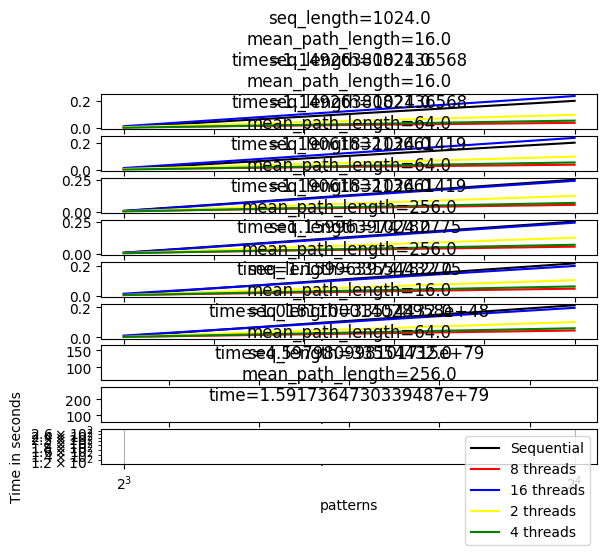

In [65]:
plot_variable_sequential_pthreads("patterns")

In [66]:
sequential[(sequential[:, 0] == 10) & (sequential[:, 2] == 4) & (sequential[:, 1] == 10)]


array([[1.000e+01, 1.000e+01, 4.000e+00, 6.302e-03]])

In [67]:
x_sequential = sequential[(sequential[:, 0] == 10) & 
               (sequential[:, 2] == 4)][:, 1]
y_sequential = sequential[(sequential[:, 0] == 10) & 
               (sequential[:, 2] == 4)][:, -1]
x_pthreads = pthreads[(pthreads[:, 0] == 2) & (pthreads[:, 1] == 10) & 
               (pthreads[:, 3] == 4)][:, 2]
y_pthreads = pthreads[(pthreads[:, 0] == 2) & (pthreads[:, 1] == 10) & 
               (pthreads[:, 3] == 4)][:, -1]
y_pthreads.shape

(2,)

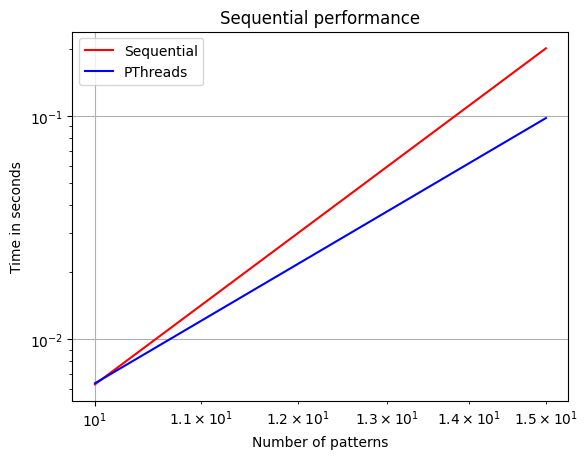

In [68]:
#plt.plot(x, y, linestyle = 'solid')
plt.plot(x_sequential, y_sequential, color='red', label = 'Sequential')
plt.plot(x_pthreads, y_pthreads, color='blue', label='PThreads')
plt.title('Sequential performance')
plt.xlabel('Number of patterns')
plt.ylabel('Time in seconds')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()